## Predicting Motor Insurance Claims
A notebook for Analytics Olympiad which was hosted by Machine Hack

### About the dataset
The dataset contains information on policyholders of motor insurance such as the type of vehicle,  annual mileage, household statistics, credit score, and more. 

For the competition, we are expected to obtain a target for prediction which is a binary value on whther the insurance claim occurred or not. The target column is the 'OUTCOME' in the dataset

### Objectives
In this notebook, we will explore the steps required to approach the classification problem of whether or not a claim occured, from start to finish.

The regression model is “by construction” an interpolation model.

A test set is also provided, the accuracy on the test set will determine the position of each candidate on the leaderboard. The log loss metric is to be used for measuring accuracy 

This notebook will guide us through an end-to-end process of:

1. Cleaning and Splitting Test Data
2. Exploratory Data Analysis
3. Feature Engineering
4. Model Selection
5. Advanced Feature Transformation
6. Fitting the Model
7. Hyperparameter Optimisation
8. Predicting Test Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
plt.rc('figure',figsize=(20,11))
sns.set_style('darkgrid')
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier, MLPRegressor

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.compose import ColumnTransformer

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, LinearSVC, SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression, Lasso

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor


c:\Users\ibola\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# 1. Cleaning and Splitting Test Data

### 1.1 Understanding the Dimensions
First, we'll look at basic descriptions of the data to understand what we're working with.

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test2 = pd.read_csv('test.csv')
train = train.drop(columns=['ID'])
train.head()

,AGE,GENDER,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME,TYPE_OF_VEHICLE
0,40-64,female,20-29y,university,middle class,0.638050,0.0,after 2015,0.0,0.0,37379,11000.0,0,0,0,0.0,Sports Car
1,26-39,male,20-29y,high school,middle class,0.475741,1.0,before 2015,1.0,0.0,10238,9000.0,0,0,0,1.0,HatchBack
2,40-64,male,20-29y,none,middle class,0.839817,1.0,before 2015,1.0,1.0,10238,12000.0,0,0,0,1.0,Sedan
3,40-64,male,20-29y,high school,upper class,0.682527,1.0,before 2015,0.0,1.0,92099,6000.0,1,0,0,1.0,Sedan
4,40-64,female,20-29y,none,working class,0.572184,1.0,after 2015,1.0,1.0,32122,15000.0,0,0,1,0.0,Sedan


In [ ]:
print(f"Dataset has {train.shape[0]} rows and {train.shape[1]} columns")
print(f"Duplicates: {train.duplicated().sum()}")
print(f"Total Missing Values: {train.isna().sum().sum()}")
print(f"Number of rows with missing values: {train.isna().any(axis=1).sum()}")
print('-------------------------------------')
print('For the test set')
print(f"\nDataset has {test.shape[0]} rows and {test.shape[1]} columns")
print(f"Duplicates: {test.duplicated().sum()}")
print(f"Total Missing Values: {test.isna().sum().sum()}")
print(f"Number of rows with missing values: {test.isna().any(axis=1).sum()}")

Dataset has 105000 rows and 17 columns
Duplicates: 0
Total Missing Values: 0
Number of rows with missing values: 0
-------------------------------------
For the test set

Dataset has 45000 rows and 17 columns
Duplicates: 0
Total Missing Values: 0
Number of rows with missing values: 0


### 1.2 Performing Clean Up of Data
We have to be careful not to fundamentally change any values relative to others while keeping in mind that we should avoid any leakage as we have not yet split our test set.


There is not much cleanup to be done as the data is basically almost perfect

In [ ]:
train.head()

,AGE,GENDER,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME,TYPE_OF_VEHICLE
0,40-64,female,20-29y,university,middle class,0.638050,0.0,after 2015,0.0,0.0,37379,11000.0,0,0,0,0.0,Sports Car
1,26-39,male,20-29y,high school,middle class,0.475741,1.0,before 2015,1.0,0.0,10238,9000.0,0,0,0,1.0,HatchBack
2,40-64,male,20-29y,none,middle class,0.839817,1.0,before 2015,1.0,1.0,10238,12000.0,0,0,0,1.0,Sedan
3,40-64,male,20-29y,high school,upper class,0.682527,1.0,before 2015,0.0,1.0,92099,6000.0,1,0,0,1.0,Sedan
4,40-64,female,20-29y,none,working class,0.572184,1.0,after 2015,1.0,1.0,32122,15000.0,0,0,1,0.0,Sedan


In [ ]:
# Let's define the categorical columns and numerical columns which will be later used as features
categorical_cols = [col for col in train.columns if (train[col].nunique() < 10) and 
                    (train[col].dtype == "object") and
                    col not in ['OUTCOME']]

numerical_cols = [col for col in train.columns if (train[col].dtype in ['int64', 'float64']) and
                  col not in ['OUTCOME']]

print('Number of Numerical columns   :',len(numerical_cols))
print('Number of Categorical columns :',len(categorical_cols))

Number of Numerical columns   : 9
Number of Categorical columns : 7


In [ ]:
train.head()

,AGE,GENDER,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME,TYPE_OF_VEHICLE
0,40-64,female,20-29y,university,middle class,0.638050,0.0,after 2015,0.0,0.0,37379,11000.0,0,0,0,0.0,Sports Car
1,26-39,male,20-29y,high school,middle class,0.475741,1.0,before 2015,1.0,0.0,10238,9000.0,0,0,0,1.0,HatchBack
2,40-64,male,20-29y,none,middle class,0.839817,1.0,before 2015,1.0,1.0,10238,12000.0,0,0,0,1.0,Sedan
3,40-64,male,20-29y,high school,upper class,0.682527,1.0,before 2015,0.0,1.0,92099,6000.0,1,0,0,1.0,Sedan
4,40-64,female,20-29y,none,working class,0.572184,1.0,after 2015,1.0,1.0,32122,15000.0,0,0,1,0.0,Sedan


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105000 entries, 0 to 104999
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   AGE                  105000 non-null  object 
 1   GENDER               105000 non-null  object 
 2   DRIVING_EXPERIENCE   105000 non-null  object 
 3   EDUCATION            105000 non-null  object 
 4   INCOME               105000 non-null  object 
 5   CREDIT_SCORE         105000 non-null  float64
 6   VEHICLE_OWNERSHIP    105000 non-null  float64
 7   VEHICLE_YEAR         105000 non-null  object 
 8   MARRIED              105000 non-null  float64
 9   CHILDREN             105000 non-null  float64
 10  POSTAL_CODE          105000 non-null  int64  
 11  ANNUAL_MILEAGE       105000 non-null  float64
 12  SPEEDING_VIOLATIONS  105000 non-null  int64  
 13  DUIS                 105000 non-null  int64  
 14  PAST_ACCIDENTS       105000 non-null  int64  
 15  OUTCOME          

In [ ]:
print(f'Dataset has {train.shape[0]} rows and {train.shape[1]} columns')
print(f'Duplicates: {train.duplicated().sum()}')
print(f'Total missing values: {train.isna().sum().sum()}')
print(f'Number of rows with missing values: {train.isna().any(axis=1).sum()}')

Dataset has 105000 rows and 17 columns
Duplicates: 0
Total missing values: 0
Number of rows with missing values: 0


The dataset is quite imbalanced as the OUTCOME variables don't have an equal distribution in the dataset

<AxesSubplot:>

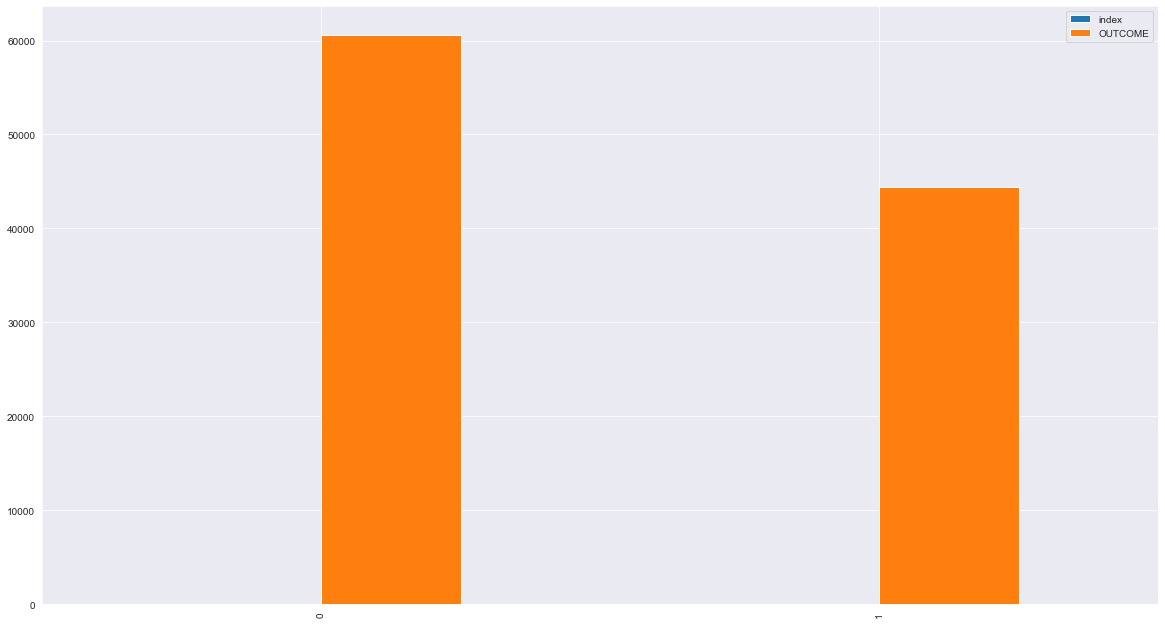

In [ ]:
train['OUTCOME'].value_counts().reset_index().plot(kind='bar')

## EXPLORATORY DATA ANALYSIS

### 2.1 FEATURE DISTRIBUTION

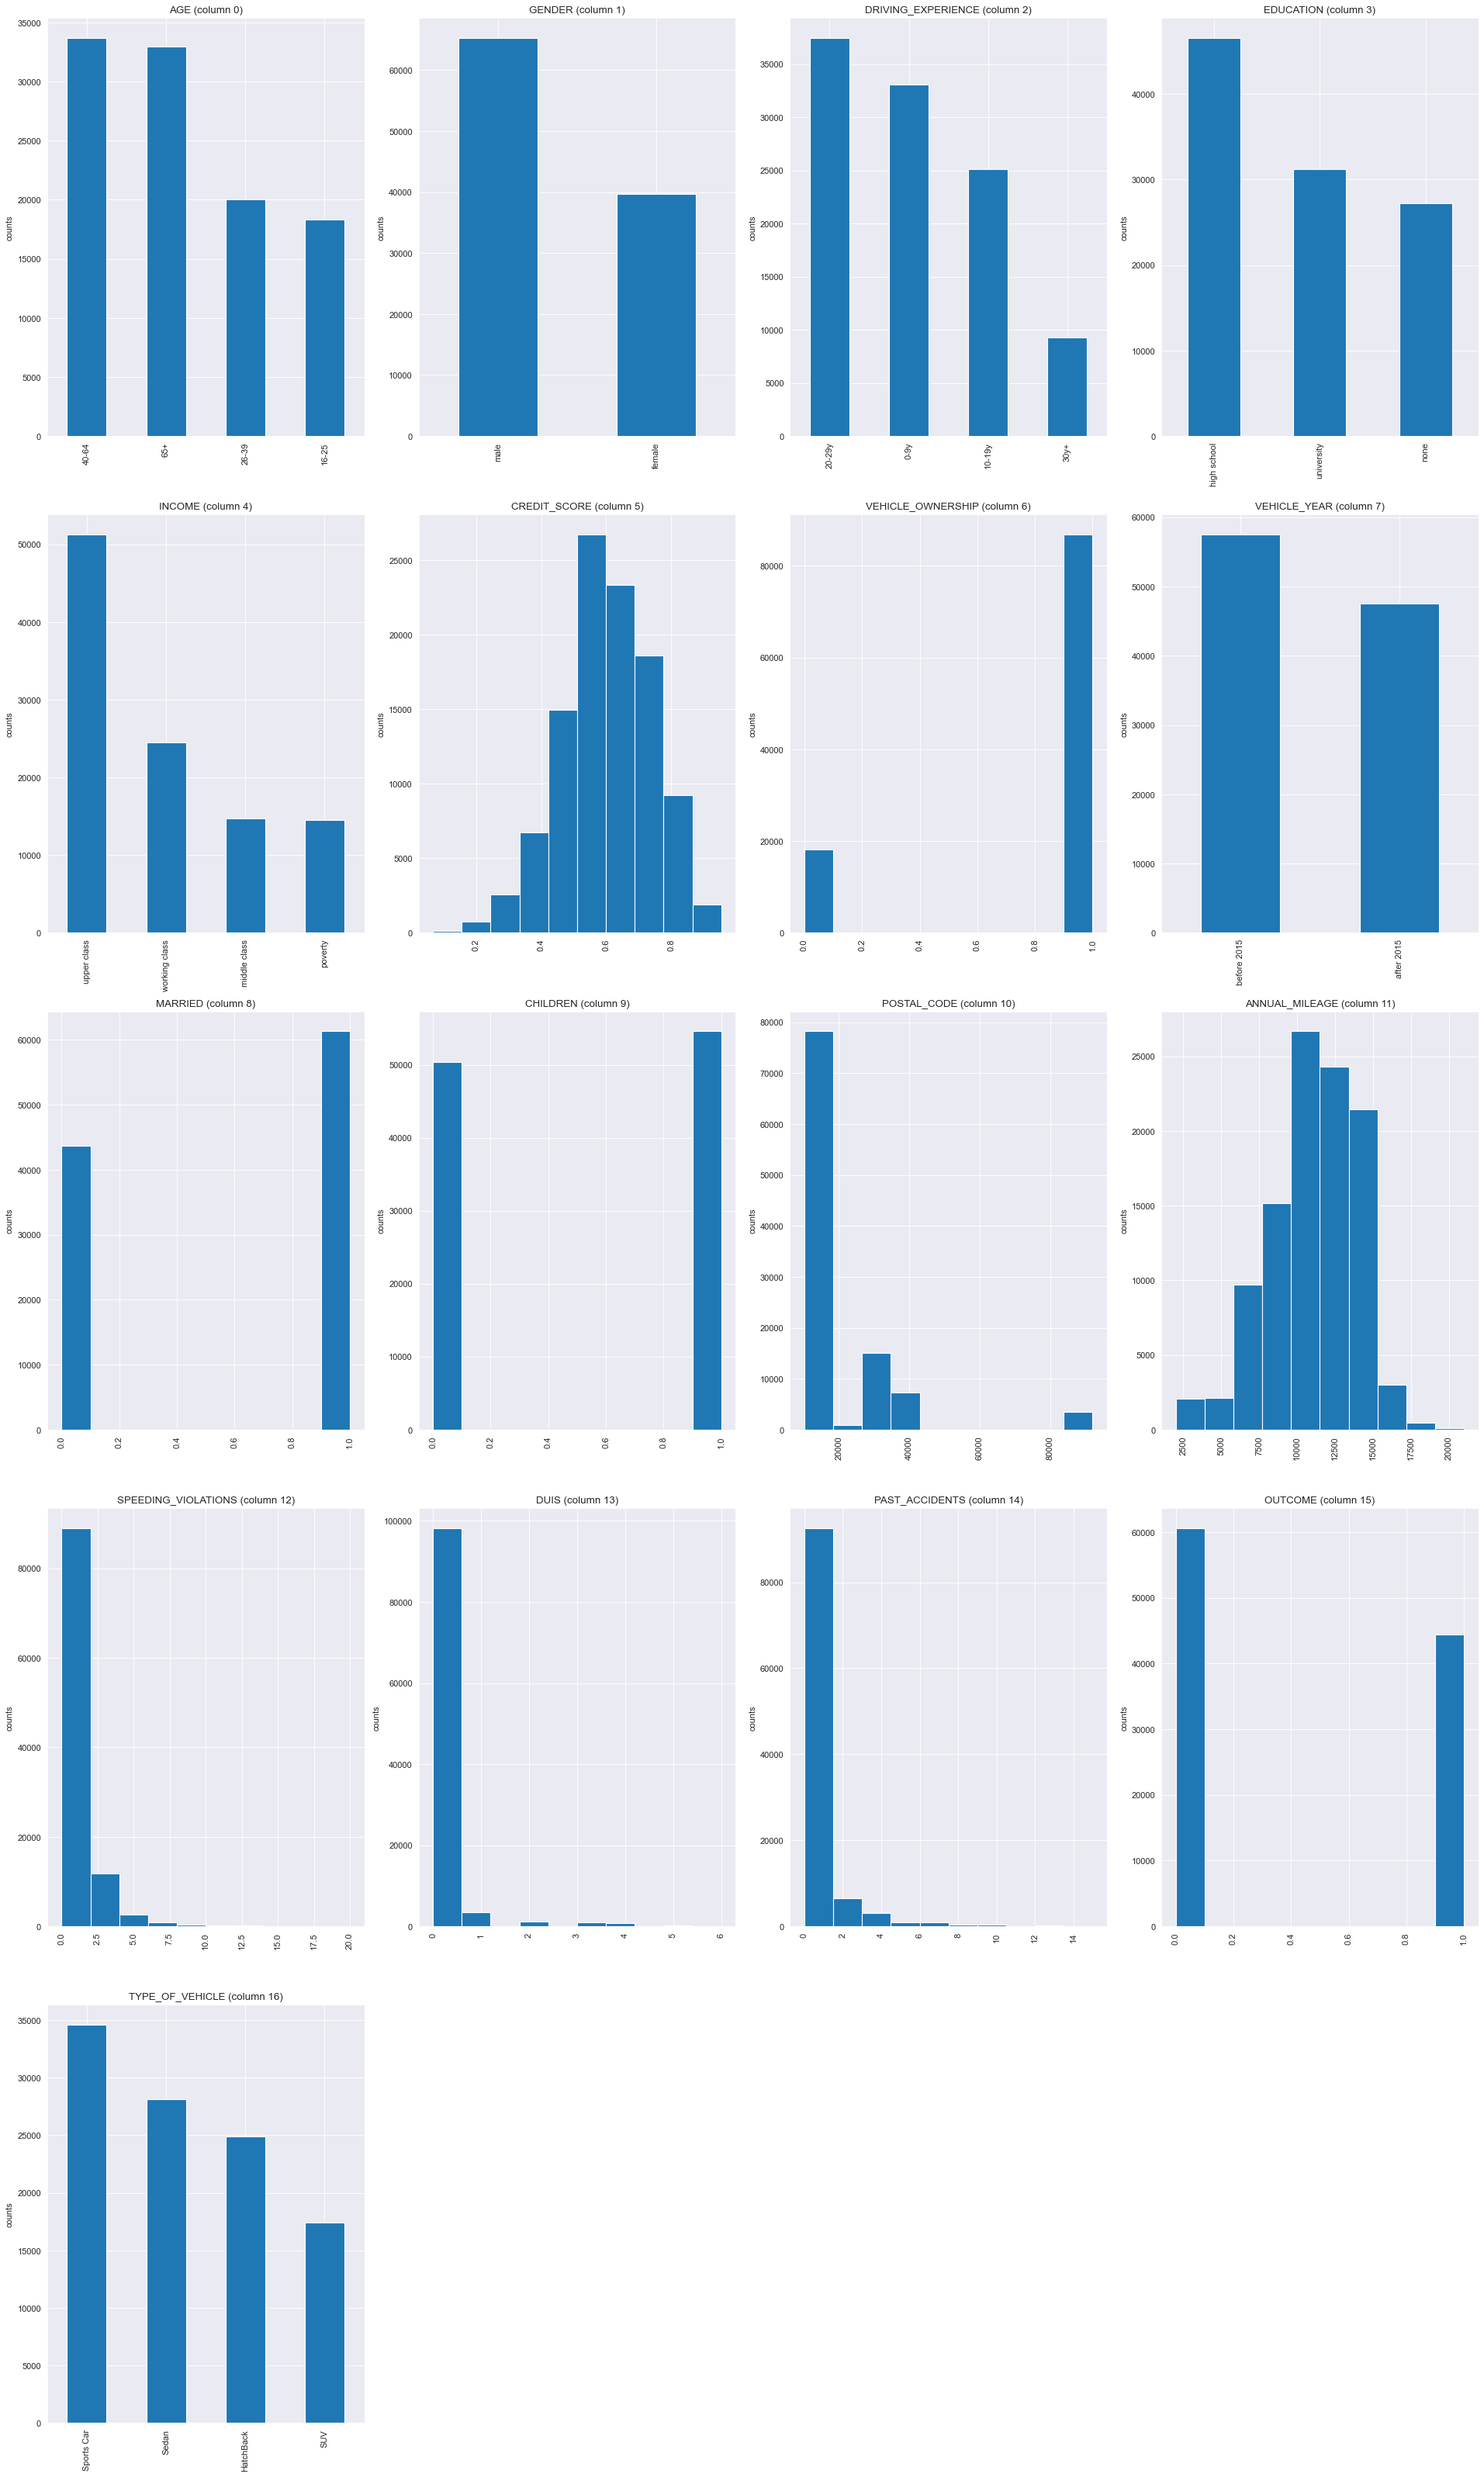

In [ ]:
def plot_col_distribution(df, n_graph_per_row):
    n_col = df.shape[1]
    column_names = list(df)
    n_graph_row = (n_col + n_graph_per_row - 1) // n_graph_per_row
    plt.figure(num = None, figsize = (6 * n_graph_per_row, 8 * n_graph_row), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(n_col):
        plt.subplot(n_graph_row, n_graph_per_row, i + 1)
        column_df = df.iloc[:, i]
        if (not np.issubdtype(type(column_df.iloc[0]), np.number)):
            column_df.value_counts().plot.bar()
        else:
            column_df.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{column_names[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()
    
plot_col_distribution(train,4)

In [ ]:
from scipy.stats import skew
for col in numerical_cols:
    print(f'{col}: {skew(train[col])}')

CREDIT_SCORE: -0.2263552331190916
VEHICLE_OWNERSHIP: -1.7293796863745652
MARRIED: -0.3414409707238864
CHILDREN: -0.08006407690254365
POSTAL_CODE: 2.986839692396651
ANNUAL_MILEAGE: -0.5101105685548738
SPEEDING_VIOLATIONS: 3.899760801440324
DUIS: 5.608607750200801
PAST_ACCIDENTS: 4.345458193673233


There appears to be quite a bit of skew in some of the numerical variables.

However, we'll do our best to preserve the structure including outliers, so that we can make the most of it.

### 2.3 Checking Correlation between Variables
Understanding how the variables are related can tell us more about whether or not features are redundant. Redundant features can negatively impact the performance of the model.

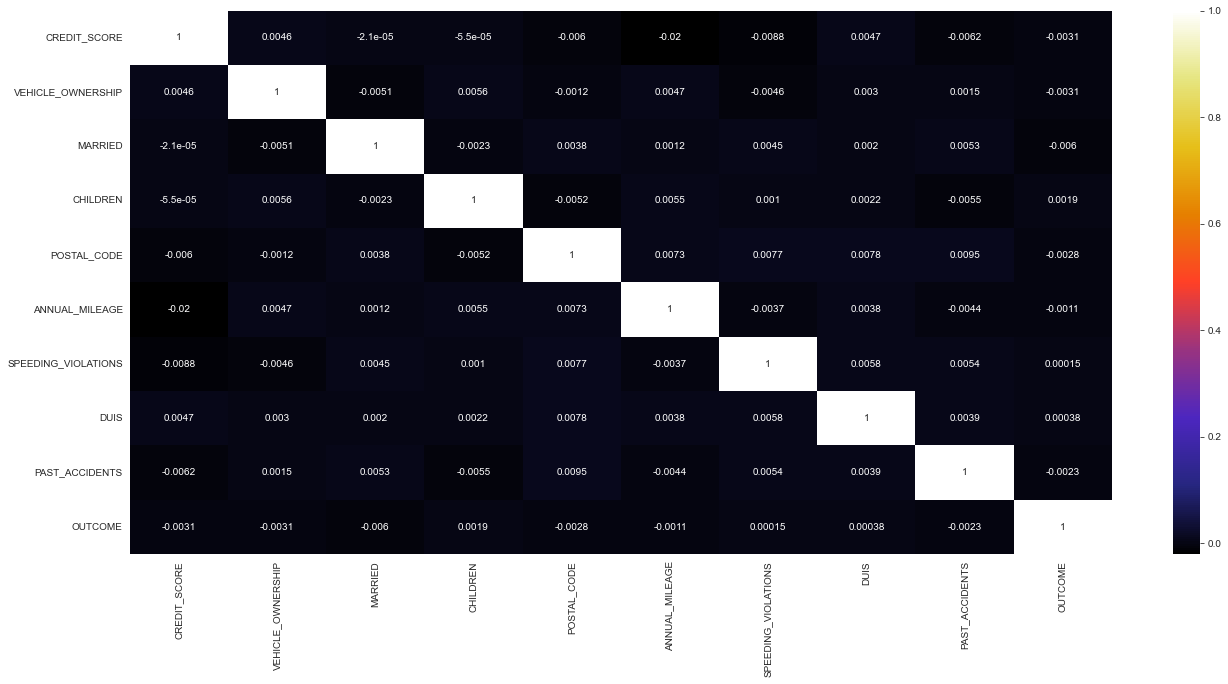

In [ ]:
def plot_corr(df):
    corr = df.corr()
    plt.figure(figsize=(22,10))
    sns.heatmap(corr, cbar=True, annot=True, cmap='CMRmap')

plot_corr(train)

Wow! There is extremely little positive correlation among the dataset variables, some variables are also a little bit negatively correlated, this shows that there's hardly any relationship that exists between these variables.

### 2.4 Number of Categories in Each Categorical Feature
Too many categories make a feature less viable as a categorical feature.

In [ ]:
for col in categorical_cols:
    print(col, 'has', train[col].nunique(),'unique variables')

AGE has 4 unique variables
GENDER has 2 unique variables
DRIVING_EXPERIENCE has 4 unique variables
EDUCATION has 3 unique variables
INCOME has 4 unique variables
VEHICLE_YEAR has 2 unique variables
TYPE_OF_VEHICLE has 4 unique variables


Fortunately, all categorical featuers have a healthy number of categories - not too many.

Some with 2 unique variables can be considered binary i.e. 2 states only.

### 2.5 Check for Missing Values


In [ ]:
print(f"Missing Values in DF: {train.isna().sum().sum()}")
print("\n")

def find_missing(df, cols:list):
    for i in cols:
        print(" - ", i, f", Missing: {df[i].isna().sum()}")
    print("\n")

print("Categorical features are:")
find_missing(train, categorical_cols)
print("Numerical features are:")
find_missing(train, numerical_cols)

print("Targets")
find_missing(train, ['OUTCOME'])

Missing Values in DF: 0


Categorical features are:
 -  AGE , Missing: 0
 -  GENDER , Missing: 0
 -  DRIVING_EXPERIENCE , Missing: 0
 -  EDUCATION , Missing: 0
 -  INCOME , Missing: 0
 -  VEHICLE_YEAR , Missing: 0
 -  TYPE_OF_VEHICLE , Missing: 0


Numerical features are:
 -  CREDIT_SCORE , Missing: 0
 -  VEHICLE_OWNERSHIP , Missing: 0
 -  MARRIED , Missing: 0
 -  CHILDREN , Missing: 0
 -  POSTAL_CODE , Missing: 0
 -  ANNUAL_MILEAGE , Missing: 0
 -  SPEEDING_VIOLATIONS , Missing: 0
 -  DUIS , Missing: 0
 -  PAST_ACCIDENTS , Missing: 0


Targets
 -  OUTCOME , Missing: 0




### 2.6 Selecting Model and Metrics
##### For the classification problem with `OUTCOME`:

This is a binary classification problem.

The chosen metric for the competition is 'log_loss' which is a measure of how close the prediction probability is close to the actual value.

### 4.3 Encoding Categorical Variables
XGBoost requires some form of encoding to function with categorical variables. 
We'll look into encoding in detail further below.

Looking at the nunique values from the EDA, and some off-screen analysis of each categorical value, there are 3 types of encoding we will perform here.

- Ordinal category: Only Education appears to have some linkage between the classes
- Binary categories: These categories have only two classes
- Nominal categories: There are multiple classes and they do not have any relationship with one another

In [ ]:
categorical_cols_ord = ['EDUCATION']
categorical_cols_bin = ['VEHICLE_YEAR', 'GENDER']
categorical_cols_nom = ['TYPE_OF_VEHICLE', 'DRIVING_EXPERIENCE', 'INCOME', 'AGE']

print('All features are accounted for:',set(categorical_cols) == set(categorical_cols_ord) | set(categorical_cols_bin) | set(categorical_cols_nom))

All features are accounted for: True


First we select the train and test columns to be encoded

Then we apply the type of encoding we have defined for each subset of data

In [ ]:
EDUCATION_ordinal = [['none', 'high school', 'university']]
ordinal_encoder_EDUCATION = OrdinalEncoder(categories=EDUCATION_ordinal)
binary_encoder = OrdinalEncoder()
oh_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

#Take only categorical columns
train_cat = train[categorical_cols]
test_cat = test[categorical_cols]

#Encode each categorical type
#Ordinal categories
train_cat_ord = pd.DataFrame(ordinal_encoder_EDUCATION.fit_transform(train_cat[categorical_cols_ord]))
train_cat_ord.columns = train_cat[categorical_cols_ord].columns

test_cat_ord = pd.DataFrame(ordinal_encoder_EDUCATION.fit_transform(test_cat[categorical_cols_ord]))
test_cat_ord.columns = test_cat[categorical_cols_ord].columns

#Binary Categories
train_cat_bin = pd.DataFrame(binary_encoder.fit_transform(train_cat[categorical_cols_bin]))
train_cat_bin.columns = train_cat[categorical_cols_bin].columns

test_cat_bin = pd.DataFrame(binary_encoder.fit_transform(test_cat[categorical_cols_bin]))
test_cat_bin.columns = test_cat[categorical_cols_bin].columns

#Nominal Categories
train_cat_nom = pd.DataFrame(oh_encoder.fit_transform(train_cat[categorical_cols_nom]))
train_cat_nom.columns = oh_encoder.get_feature_names_out()

test_cat_nom = pd.DataFrame(oh_encoder.fit_transform(test_cat[categorical_cols_nom]))
test_cat_nom.columns = oh_encoder.get_feature_names_out()

#Rejoin the three sub df's

train_cat_enc = pd.concat([train_cat_ord, train_cat_nom, train_cat_bin], axis=1)

test_cat_enc = pd.concat([test_cat_ord, test_cat_nom, test_cat_bin], axis=1)

train_cat_enc.head()


,EDUCATION,TYPE_OF_VEHICLE_HatchBack,TYPE_OF_VEHICLE_SUV,TYPE_OF_VEHICLE_Sedan,TYPE_OF_VEHICLE_Sports Car,DRIVING_EXPERIENCE_0-9y,DRIVING_EXPERIENCE_10-19y,DRIVING_EXPERIENCE_20-29y,DRIVING_EXPERIENCE_30y+,INCOME_middle class,INCOME_poverty,INCOME_upper class,INCOME_working class,AGE_16-25,AGE_26-39,AGE_40-64,AGE_65+,VEHICLE_YEAR,GENDER
0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
test_cat_enc.head()

,EDUCATION,TYPE_OF_VEHICLE_HatchBack,TYPE_OF_VEHICLE_SUV,TYPE_OF_VEHICLE_Sedan,TYPE_OF_VEHICLE_Sports Car,DRIVING_EXPERIENCE_0-9y,DRIVING_EXPERIENCE_10-19y,DRIVING_EXPERIENCE_20-29y,DRIVING_EXPERIENCE_30y+,INCOME_middle class,INCOME_poverty,INCOME_upper class,INCOME_working class,AGE_16-25,AGE_26-39,AGE_40-64,AGE_65+,VEHICLE_YEAR,GENDER
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [ ]:
train_complete_enc = pd.concat([train[numerical_cols], train_cat_enc, train['OUTCOME']], axis=1)
test_complete_enc = pd.concat([test[numerical_cols], test_cat_enc], axis=1)

train_complete_enc.head()

,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,EDUCATION,...,INCOME_poverty,INCOME_upper class,INCOME_working class,AGE_16-25,AGE_26-39,AGE_40-64,AGE_65+,VEHICLE_YEAR,GENDER,OUTCOME
0,0.638050,0.0,0.0,0.0,37379,11000.0,0,0,0,2.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.475741,1.0,1.0,0.0,10238,9000.0,0,0,0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0
2,0.839817,1.0,1.0,1.0,10238,12000.0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
3,0.682527,1.0,0.0,1.0,92099,6000.0,1,0,0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
4,0.572184,1.0,1.0,1.0,32122,15000.0,0,0,1,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
test_complete_enc.head()

,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,EDUCATION,...,INCOME_middle class,INCOME_poverty,INCOME_upper class,INCOME_working class,AGE_16-25,AGE_26-39,AGE_40-64,AGE_65+,VEHICLE_YEAR,GENDER
0,0.814707,1.0,0.0,1.0,10238,10000.0,0,0,0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.344051,1.0,0.0,0.0,34073,13000.0,0,0,0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.620691,0.0,1.0,0.0,10238,12000.0,0,0,0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.689658,1.0,1.0,1.0,10238,16000.0,1,0,0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.755666,0.0,0.0,1.0,92101,14000.0,2,0,0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [ ]:
train_complete_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105000 entries, 0 to 104999
Data columns (total 29 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   CREDIT_SCORE                105000 non-null  float64
 1   VEHICLE_OWNERSHIP           105000 non-null  float64
 2   MARRIED                     105000 non-null  float64
 3   CHILDREN                    105000 non-null  float64
 4   POSTAL_CODE                 105000 non-null  int64  
 5   ANNUAL_MILEAGE              105000 non-null  float64
 6   SPEEDING_VIOLATIONS         105000 non-null  int64  
 7   DUIS                        105000 non-null  int64  
 8   PAST_ACCIDENTS              105000 non-null  int64  
 9   EDUCATION                   105000 non-null  float64
 10  TYPE_OF_VEHICLE_HatchBack   105000 non-null  float64
 11  TYPE_OF_VEHICLE_SUV         105000 non-null  float64
 12  TYPE_OF_VEHICLE_Sedan       105000 non-null  float64
 13  TYPE_OF_VEHICL


### 4.4 Dummy Variable Trap
One of the downsides of one-hot encoding is that we can fall into the Dummy Variable Trap. To avoid problems with Multicollinearity, let's look into the one-hot encoded variables.

A common practice is to drop one of the columns for each encoding, but let's evaluate how doing so reduces multicollinearity

One of the common ways to check for multicollinearity is the Variance Inflation Factor (VIF):

- VIF = 1 : Very little Multicollinearity
- VIF < 5 : Moderate Multicollinearity
- VIF > 5 : Extreme Multicollinearity (This is what we have to avoid)

In [ ]:
def calc_vif(df):
    df_cols = df.columns
    vif_values = [
        variance_inflation_factor(df.values, i) for i in range(len(df_cols))
        ]
    return pd.DataFrame(zip(df_cols, vif_values),columns=['Variable','VIF'])

calc_vif(train_complete_enc.drop(['OUTCOME'], axis=1))

c:\Users\ibola\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Variable,VIF
0,CREDIT_SCORE,1.001328
1,VEHICLE_OWNERSHIP,1.000319
2,MARRIED,1.000213
3,CHILDREN,1.000513
4,POSTAL_CODE,1.000543
5,ANNUAL_MILEAGE,1.000788
6,SPEEDING_VIOLATIONS,1.000534
7,DUIS,1.000317
8,PAST_ACCIDENTS,1.000451
9,EDUCATION,1.000363


As expected, the one-hot encoded variables displayed infinite VIF, which means we have to drop one of each of the newly encoded features.

In [ ]:
train_complete_enc.drop(columns=['TYPE_OF_VEHICLE_HatchBack', 'DRIVING_EXPERIENCE_0-9y','INCOME_middle class', 'AGE_16-25', 'GENDER', 'INCOME_poverty', 'INCOME_upper class',], inplace=True)
test_complete_enc.drop(columns=['TYPE_OF_VEHICLE_HatchBack', 'DRIVING_EXPERIENCE_0-9y','INCOME_middle class', 'AGE_16-25', 'GENDER', 'INCOME_poverty', 'INCOME_upper class'], inplace=True)
calc_vif(train_complete_enc.drop(['OUTCOME'], axis=1))

,Variable,VIF
0,CREDIT_SCORE,13.172672
1,VEHICLE_OWNERSHIP,5.316960
2,MARRIED,2.345695
3,CHILDREN,2.046077
4,POSTAL_CODE,2.123203
5,ANNUAL_MILEAGE,11.071985
6,SPEEDING_VIOLATIONS,1.233168
7,DUIS,1.048347
8,PAST_ACCIDENTS,1.150076
9,EDUCATION,2.849990


# 5. Model Selection
We'll select a list of popular classifiers to compare how they fare with our selected metric.

The tests here will be brief without any deeper optimisation.

In [ ]:
# Model selection
classifiers = [

    ('Nearest Neighbors', KNeighborsClassifier(3)),
    
    ('Decision Tree', DecisionTreeClassifier(random_state=0, max_depth=5)),
    ('Random Forest', RandomForestClassifier(random_state=0, max_depth=5, n_estimators=10, max_features=1)),
    ('Neural Net', MLPClassifier(random_state=0, alpha=1, max_iter=1000)),
    ('AdaBoost', AdaBoostClassifier(random_state=0)),
    ('Naive Bayes', GaussianNB()),
    ('QDA', QuadraticDiscriminantAnalysis()),
    ('XGBoost', XGBClassifier(random_state=0, silent=True)),
    ('GBM Classifier', GradientBoostingClassifier(random_state=0))]

Removing our target variable...

In [ ]:
y = train_complete_enc['OUTCOME']
train_complete_enc = train_complete_enc.drop(columns=['OUTCOME'])

In [ ]:
train_complete_enc.head()

,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,EDUCATION,...,TYPE_OF_VEHICLE_Sedan,TYPE_OF_VEHICLE_Sports Car,DRIVING_EXPERIENCE_10-19y,DRIVING_EXPERIENCE_20-29y,DRIVING_EXPERIENCE_30y+,INCOME_working class,AGE_26-39,AGE_40-64,AGE_65+,VEHICLE_YEAR
0,0.638050,0.0,0.0,0.0,37379,11000.0,0,0,0,2.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.475741,1.0,1.0,0.0,10238,9000.0,0,0,0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.839817,1.0,1.0,1.0,10238,12000.0,0,0,0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.682527,1.0,0.0,1.0,92099,6000.0,1,0,0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.572184,1.0,1.0,1.0,32122,15000.0,0,0,1,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


We're going to split dataset into train and test sets and stratify to reflect the distribution of outcomes in the target variables

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_complete_enc, y, test_size=0.2, stratify=y)
y_train.value_counts()
y_test.value_counts()

0.0    12124
1.0     8876
Name: OUTCOME, dtype: int64

In [ ]:
from sklearn.metrics import log_loss
performance = []
for name, clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)
    perf_tuple = (name, log_loss(y_test, y_pred))
    print(perf_tuple)
    performance.append(perf_tuple)

('Nearest Neighbors', 4.810397519006176)
('Decision Tree', 0.6820750249551144)
('Random Forest', 0.6811349518465778)
('Neural Net', 6.947401648609969)
('AdaBoost', 0.6926256812918044)
('Naive Bayes', 0.6817753112478834)
('QDA', 0.6855312053772572)
[17:56:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




c:\Users\ibola\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\ibola\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:56:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
('XGBoost', 0.6884704669408855)
('GBM Classifier', 0.6813877477099461)


From the above, we can see clearly that all 3 of the GBM, XGBoost, RandomForest and AdaBoost Classifiers performed similarly, these results are enough for us to decide to proceed with a GBM variant.

Although RandomForest performed marginally better here, we'll use XGBoost since it's the more advanced, more tuneable algorithm.

Thus, we'll focus on performing more specific transformations to aid XGBoost.

# 6. Advanced Feature Transformations
In order to support the selected model, we should consider how to transform the dataset such that they can improve the performance of the model.

In [ ]:
from sklearn.metrics import log_loss
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict_proba(X_test)
print(log_loss(y_test, y_pred))

c:\Users\ibola\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\ibola\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:57:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6884704669408855


<span style="color:red">After getting this score, I made prediction on the validation set and uploaded my submissions file to the leaderboard. My model was severely overfitting as I had a score of around 1.9 on the validation set and my position on the leaderboard was wayyyyy down.</span>


### 6.1 Feature Extraction
Sometimes, we can perform Feature Extraction but in our dataset, most features are straightforward and need no further extraction

### 6.2 Numerical only for XGBoost
XGBoost works with numerical data only, and fortunately our base dataframe is already encoded into numerical features.

### 6.3 Feature Scaling
Decision Tree based classifiers, which XGBoost is based on, are insensitive to scaling.

### 6.4 Feature Selection
We can reduce dimensionality but XGBoost naturally handles this usually. 

Nevertheless, let's experiment with two methods of dimensionality reduction, namely Recursive Feature Elimination (RFE) and our old friend Variance Inflation Factor (VIF)

##### 6.4.1 Recursive Feature Elimination
Let's assume a simple model (to reduce run time)[](http://), such as a Decision Tree Classifier, to help us decide which features to eliminate.

In [ ]:
from sklearn.pipeline import Pipeline

rfe = RFE(
estimator=DecisionTreeClassifier(),
n_features_to_select=10
)

pipe = Pipeline([('rfe',rfe)])
transformed_df_rfe = pipe.fit_transform(X_train, y_train)
support = pipe.named_steps['rfe'].support_
drop_cols_rfe = list(X_train.columns[support])

##### 6.4.2 Variance Inflation Factor Selection
Just as we have performed after the One-hot Encoding, we can perform the same selection, by removing features with a VIF greater than 5.

In [ ]:
vif_df = calc_vif(X_train)
drop_cols_vif = vif_df.loc[vif_df['VIF']>5]['Variable'].values
transformed_df_rfe_vif = X_train.drop(drop_cols_vif,axis=1)
display(calc_vif(transformed_df_rfe_vif))

,Variable,VIF
0,MARRIED,2.225029
1,CHILDREN,1.958233
2,POSTAL_CODE,2.032029
3,SPEEDING_VIOLATIONS,1.226600
4,DUIS,1.047179
5,PAST_ACCIDENTS,1.145220
6,EDUCATION,2.640323
7,TYPE_OF_VEHICLE_SUV,1.542604
8,TYPE_OF_VEHICLE_Sedan,1.876146
9,TYPE_OF_VEHICLE_Sports Car,2.069083


We print out list of columns that the RFE and VIF has suggested to drop

In [ ]:
print('RFE - Columns to be dropped:', list(drop_cols_rfe))
print('VIF - Columns to be dropped:', list(drop_cols_vif))


RFE - Columns to be dropped: ['CREDIT_SCORE', 'CHILDREN', 'POSTAL_CODE', 'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'EDUCATION', 'TYPE_OF_VEHICLE_Sedan', 'INCOME_working class', 'AGE_40-64', 'VEHICLE_YEAR']
VIF - Columns to be dropped: ['CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'ANNUAL_MILEAGE']


And we remove columns that are common to both lists

In [ ]:
transformed_train = train_complete_enc.drop(columns=['CREDIT_SCORE', 'ANNUAL_MILEAGE'])
X_train, X_test, y_train, y_test = train_test_split(transformed_train, y, test_size=0.2, stratify=y)

In [ ]:
xgb = XGBClassifier(silent=True)
xgb.fit(X_train, y_train)
y_pred = xgb.predict_proba(X_test)
print(log_loss(y_test, y_pred))

c:\Users\ibola\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\ibola\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:58:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:58:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.687769487236582


We can see that the feature selection had no change in our log_loss score

<span style="color:red">I made prediction again and submitted and my model was still overfitting</span>


### 6.5 Log Transformation

Here we transform our skewed features

In [ ]:
high_skew_features = []

for col in numerical_cols:
    skewness = skew(train_complete_enc[col])
    asterisk = '* ' if skewness > 1 else ''
    print(f"{asterisk}{col} : {skewness}")
    if skewness > 1:
        high_skew_features.append(col)

CREDIT_SCORE : -0.2263552331190916
VEHICLE_OWNERSHIP : -1.7293796863745652
MARRIED : -0.3414409707238864
CHILDREN : -0.08006407690254365
* POSTAL_CODE : 2.986839692396651
ANNUAL_MILEAGE : -0.5101105685548738
* SPEEDING_VIOLATIONS : 3.899760801440324
* DUIS : 5.608607750200801
* PAST_ACCIDENTS : 4.345458193673233


In [ ]:
transformed_df_log = train_complete_enc.copy()
transformed_test_log = test_complete_enc.copy()
for col in high_skew_features:
    transformed_df_log['log_'+col] = np.log(1 + transformed_df_log[col])
    transformed_test_log['log_'+col] = np.log(1 + transformed_test_log[col])

transformed_df_log.drop(high_skew_features, axis=1)
transformed_test_log.drop(high_skew_features, axis=1)
transformed_df_log.head()

,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,EDUCATION,...,DRIVING_EXPERIENCE_30y+,INCOME_working class,AGE_26-39,AGE_40-64,AGE_65+,VEHICLE_YEAR,log_POSTAL_CODE,log_SPEEDING_VIOLATIONS,log_DUIS,log_PAST_ACCIDENTS
0,0.638050,0.0,0.0,0.0,37379,11000.0,0,0,0,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,10.528891,0.000000,0.0,0.000000
1,0.475741,1.0,1.0,0.0,10238,9000.0,0,0,0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,9.233959,0.000000,0.0,0.000000
2,0.839817,1.0,1.0,1.0,10238,12000.0,0,0,0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,9.233959,0.000000,0.0,0.000000
3,0.682527,1.0,0.0,1.0,92099,6000.0,1,0,0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,11.430630,0.693147,0.0,0.000000
4,0.572184,1.0,1.0,1.0,32122,15000.0,0,0,1,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,10.377328,0.000000,0.0,0.693147


# 7. Fitting the Model

Before fitting the model finally, I'm going to try to optimize the model by tuning hyperparameters

In [ ]:
import optuna
import xgboost as xgb
from sklearn.metrics import log_loss
def objective(trial,data=transformed_df_log,target=y):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.15,random_state=42)
    param = {
        'tree_method':'auto',
        'silent' : True,
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': 10000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17]),
        'random_state': trial.suggest_categorical('random_state', [2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = xgb.XGBClassifier(**param)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(test_x)
    
    accuracy = log_loss(test_y, preds)
    
    return accuracy

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-10-15 17:58:17,742] A new study created in memory with name: no-name-462893f6-d29d-4961-899b-dd6f7fd85e3f
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
c:\Users\ibola\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, 

[17:58:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:58:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-10-15 17:59:01,535] Trial 0 finished with value: 14.65759922668968 and parameters: {'lambda': 0.7686173028084616, 'alpha': 0.003631386682337833, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 86}. Best is trial 0 with value: 14.65759922668968.
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha'

[17:59:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:59:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-10-15 17:59:55,854] Trial 1 finished with value: 14.657598820544953 and parameters: {'lambda': 9.906987034584974, 'alpha': 0.019144337867390362, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 159}. Best is trial 1 with value: 14.657598820544953.
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha

[17:59:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:59:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-10-15 18:00:44,682] Trial 2 finished with value: 14.657598820544953 and parameters: {'lambda': 0.004348936521242518, 'alpha': 0.0013859215810554035, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 263}. Best is trial 1 with value: 14.657598820544953.
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('al

[18:00:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:00:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-10-15 18:01:25,841] Trial 3 finished with value: 14.659791809496847 and parameters: {'lambda': 0.04390566230228213, 'alpha': 0.23595553134229144, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.016, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 53}. Best is trial 1 with value: 14.657598820544953.
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alph

[18:01:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:01:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-10-15 18:02:09,490] Trial 4 finished with value: 14.664177787400636 and parameters: {'lambda': 0.3487692243737889, 'alpha': 0.11459421157312003, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.016, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 71}. Best is trial 1 with value: 14.657598820544953.
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha

[18:02:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:02:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-10-15 18:02:58,600] Trial 5 finished with value: 14.657598820544953 and parameters: {'lambda': 1.894083267162785, 'alpha': 0.03879461642516999, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.01, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 297}. Best is trial 1 with value: 14.657598820544953.
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha'

[18:02:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:02:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-10-15 18:03:46,435] Trial 6 finished with value: 14.668565796028057 and parameters: {'lambda': 0.04159882706518055, 'alpha': 0.0010415616306462276, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 29}. Best is trial 1 with value: 14.657598820544953.
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alp

[18:03:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:03:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-10-15 18:04:11,973] Trial 7 finished with value: 14.657598820544953 and parameters: {'lambda': 0.021917222262451103, 'alpha': 0.009190308433997318, 'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.018, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 260}. Best is trial 1 with value: 14.657598820544953.
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('a

[18:04:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:04:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-10-15 18:04:38,991] Trial 8 finished with value: 14.657598820544953 and parameters: {'lambda': 0.0034889124481691986, 'alpha': 0.3677700803688271, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 269}. Best is trial 1 with value: 14.657598820544953.
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alp

[18:04:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:04:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-10-15 18:05:11,836] Trial 9 finished with value: 14.657598820544953 and parameters: {'lambda': 0.01014035142312957, 'alpha': 0.07401105429562205, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.012, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 170}. Best is trial 1 with value: 14.657598820544953.
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alph

[18:05:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:05:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-10-15 18:05:57,148] Trial 10 finished with value: 14.657598820544953 and parameters: {'lambda': 7.6845199402764255, 'alpha': 4.496894670926277, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.008, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 181}. Best is trial 1 with value: 14.657598820544953.
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha'

[18:05:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:05:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-10-15 18:06:20,659] Trial 11 finished with value: 14.657598820544953 and parameters: {'lambda': 0.0022860228330446523, 'alpha': 0.010608695905498448, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 223}. Best is trial 1 with value: 14.657598820544953.
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('a

[18:06:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:06:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-10-15 18:06:55,199] Trial 12 finished with value: 14.657598820544953 and parameters: {'lambda': 0.0010313560640449835, 'alpha': 0.001152459265866441, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 137}. Best is trial 1 with value: 14.657598820544953.
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('a

[18:06:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:06:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-10-15 18:08:24,457] Trial 13 finished with value: 14.657598820544953 and parameters: {'lambda': 0.16407300755508963, 'alpha': 0.014981768966225384, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 119}. Best is trial 1 with value: 14.657598820544953.
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alp

[18:08:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:08:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-10-15 18:10:08,878] Trial 14 finished with value: 14.657598820544953 and parameters: {'lambda': 5.155063021538977, 'alpha': 1.8361349513548315, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 213}. Best is trial 1 with value: 14.657598820544953.
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha'

[18:10:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:10:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-10-15 18:11:11,445] Trial 15 finished with value: 14.657598820544953 and parameters: {'lambda': 0.006538824412163164, 'alpha': 0.003383873709569485, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.012, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 225}. Best is trial 1 with value: 14.657598820544953.
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('

[18:11:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:11:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-10-15 18:11:57,032] Trial 16 finished with value: 14.657598820544953 and parameters: {'lambda': 0.19002641677626195, 'alpha': 0.03060204694996582, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.014, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 116}. Best is trial 1 with value: 14.657598820544953.
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alp

[18:11:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:11:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-10-15 18:12:34,079] Trial 17 finished with value: 14.657598820544953 and parameters: {'lambda': 1.372439281898112, 'alpha': 1.12044889374269, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 231}. Best is trial 1 with value: 14.657598820544953.
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 

[18:12:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:12:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-10-15 18:13:08,004] Trial 18 finished with value: 14.657598820544953 and parameters: {'lambda': 0.006561514156017131, 'alpha': 0.1929845673838923, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.012, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 289}. Best is trial 1 with value: 14.657598820544953.
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('al

[18:13:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:13:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-10-15 18:13:40,001] Trial 19 finished with value: 14.65540588236115 and parameters: {'lambda': 0.017879841381129295, 'alpha': 0.07726616874988707, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 105}. Best is trial 19 with value: 14.65540588236115.
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alp

[18:13:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:13:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-10-15 18:14:13,073] Trial 20 finished with value: 14.681722917449973 and parameters: {'lambda': 0.721820860364772, 'alpha': 0.7446851743865067, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 16}. Best is trial 19 with value: 14.65540588236115.
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha',

[18:14:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:14:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-10-15 18:15:02,200] Trial 21 finished with value: 14.657598820544953 and parameters: {'lambda': 8.758448105432189, 'alpha': 8.299770514273037, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.008, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 170}. Best is trial 19 with value: 14.65540588236115.
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha',

[18:15:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:15:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-10-15 18:15:29,312] Trial 22 finished with value: 14.657598820544953 and parameters: {'lambda': 0.015519629128575973, 'alpha': 9.010826962086902, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 193}. Best is trial 19 with value: 14.65540588236115.
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alph

[18:15:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:15:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-10-15 18:15:58,398] Trial 23 finished with value: 14.657598820544953 and parameters: {'lambda': 0.0015844596243100458, 'alpha': 0.13824597299702387, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.012, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 294}. Best is trial 19 with value: 14.65540588236115.
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('

[18:15:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:15:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-10-15 18:16:37,427] Trial 24 finished with value: 14.65540588236115 and parameters: {'lambda': 0.05084565646153446, 'alpha': 0.006500894560534061, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.008, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 102}. Best is trial 19 with value: 14.65540588236115.
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alp

[18:16:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:16:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-10-15 18:17:17,739] Trial 25 finished with value: 14.657598820544953 and parameters: {'lambda': 0.05623295108681851, 'alpha': 0.05198234936679504, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.008, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 94}. Best is trial 19 with value: 14.65540588236115.
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alph

[18:17:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:17:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-10-15 18:17:42,076] Trial 26 finished with value: 14.65540588236115 and parameters: {'lambda': 0.0010744458564293411, 'alpha': 0.0034647474092885577, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 126}. Best is trial 19 with value: 14.65540588236115.
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('

[18:17:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:17:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-10-15 18:18:20,295] Trial 27 finished with value: 14.653212944177346 and parameters: {'lambda': 0.09630183514147887, 'alpha': 0.0036670421329471573, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 136}. Best is trial 27 with value: 14.653212944177346.
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('

[18:18:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:18:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-10-15 18:18:50,323] Trial 28 finished with value: 14.65540588236115 and parameters: {'lambda': 0.08700237211719201, 'alpha': 0.005150766436414884, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 96}. Best is trial 27 with value: 14.653212944177346.
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\ibola\AppData\Local\Temp\ipykernel_5576\41865496.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alp

[18:18:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:18:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-10-15 18:19:19,010] Trial 29 finished with value: 14.657598820544953 and parameters: {'lambda': 0.12054422114936367, 'alpha': 0.003039519600787159, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 138}. Best is trial 27 with value: 14.653212944177346.


Number of finished trials: 30
Best trial: {'lambda': 0.09630183514147887, 'alpha': 0.0036670421329471573, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 136}


In [ ]:
#plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
optuna.visualization.plot_optimization_history(study)

In [ ]:
#plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
#Visualize parameter importances.
optuna.visualization.plot_param_importances(study)

Finally, we get a list of our optimal hyperparameters and then train the final model with it

In [ ]:
Best_trial = study.best_trial.params
Best_trial["n_estimators"], Best_trial["tree_method"] = 10000, 'auto'
Best_trial

{'lambda': 0.09630183514147887,
 'alpha': 0.0036670421329471573,
 'colsample_bytree': 0.7,
 'subsample': 1.0,
 'learning_rate': 0.018,
 'max_depth': 9,
 'random_state': 2020,
 'min_child_weight': 136,
 'n_estimators': 10000,
 'tree_method': 'auto'}

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(transformed_df_log, y, test_size=0.2, stratify=y)
model = xgb.XGBClassifier(**Best_trial)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)
print(log_loss(y_test, y_pred))

c:\Users\ibola\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

c:\Users\ibola\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[18:19:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6875333247369244


In [ ]:
sub_file = pd.DataFrame(model.predict_proba(transformed_test_log))

In [ ]:
def pred(value):
    if value>= 0.5:
        return 1
    else:
        return 0

In [ ]:
sub_file['OUTCOME'] = sub_file[0].apply(lambda x: pred(x))
sub_file.drop(columns=[0, 1], inplace=True)
sub_file.to_csv('baseline3.csv')

 <span style="color:red">I was able to get rid of overfitting eventually and scored 0.69 on the validaton set, at this time of submission, I was 65th on the leaderboard, the first has a score of 0.68</span>
 
 
 I will also keep trying to make my score better, hopefully before the deadline


Great! That wraps up our prediction on the Insurance claim!

# Conclusion
Hope you've enjoyed this journey with me.

There are so many differing methodologies out there, and this one is mine.

There's probably several areas in this notebook that could have been improved upon but I wish I had more time to dive deeper into.

If you have a better suggestion on how one could improve the model, feel free to comment! I'm always open to constructive feedback on improving my work.

-----

### About the Author

Hi, I'm Bola, a passionate data scientist, understanding the world through data and models.

I may be available for Data Science work and more, please feel free to leave me an email here (no spam please!): ibolarinwa606@gmail.com

Let's chat more if we're a good fit. Don't overfit! ;)

Always learning.